# EMNIST

## Import

In [1]:
from pathlib import Path

BASE_DIR = Path('/Users/efraflores/Desktop/EF/Diplo/data/04')

In [2]:
import pandas as pd

df = pd.read_csv(BASE_DIR.joinpath('letters.csv')).set_index('letter').drop('Unnamed: 0',1)

df.sample()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
letter,,,,,,,,,,,,,,,,,,,,,
I,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Functions

### Timing and tone

In [3]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

### Show number

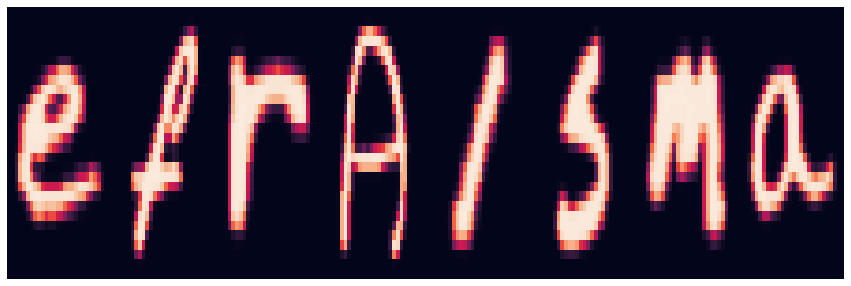

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_word(data, word='V'):
    df = data.copy()

    fig, axes = plt.subplots(1, len(word), figsize=(15, 5), sharey=True)
    for i,letter in enumerate(word):
        same_letter = df.loc[letter,:]
        one_letter = np.array(same_letter.sample()).reshape((28,28))
        sns.heatmap(pd.DataFrame(one_letter), ax=axes[i], cbar=False, xticklabels=False, yticklabels=False)
    plt.subplots_adjust(wspace = .001)
    plt.show()

show_word(df, 'EFRAISMA')

### ANN builder

In [5]:
from keras import Input
from keras.layers import Dense, LeakyReLU
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

def ann_sequential_builder(X, y, layer_units, activations):
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    for layer,activ in zip(layer_units, activations):
        model.add(Dense(units=layer,activation=activ))
    y = to_categorical(y)
    last_layer,last_activ = (1,'sigmoid') if y[0].shape[0]<=2 else (y[0].shape[0],'softmax')
    model.add(Dense(last_layer, last_activ))
    print(model.summary())
    return model, y

### Confussion Matrix SKLEARN

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def cm_sklearn(X, y, fit_model):
    cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=fit_model.predict(X)),
                    index=fit_model.classes_,
                    columns=fit_model.classes_).replace({0:np.nan})
    print('Accuracy de {:.2%}'.format(np.asarray(cm).trace()/len(y_test)))

    size = int(len(np.unique(y))/2)
    fig, ax = plt.subplots(figsize=(size,size)) 
    sns.heatmap(pd.DataFrame([cm[col]/cm[col].sum() for col in cm.columns]), 
                annot = True,
                fmt = '.0%',
                cmap = 'Blues',
                linewidths = 0.5, 
                ax = ax)
    plt.show()
    return cm

### Confussion Matrix KERAS

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def cm_keras(X, y, fit_model, label_encod=None):
    y_real = [np.argmax(x) for x in y]
    y_predicted = [np.argmax(x).reshape(-1,)[0] for x in fit_model.predict(X)]

    if label_encod == None: pass
    else: 
        y_real = label_encod.inverse_transform(y_real)
        y_predicted = label_encod.inverse_transform(y_predicted)

    cm = pd.DataFrame(confusion_matrix(y_true=y_real, y_pred=y_predicted),
                    index=label_encod.classes_ if label_encod!=None else label_encod,
                    columns=label_encod.classes_ if label_encod!=None else label_encod).replace({0:np.nan})

    print('Accuracy de {:.2%}'.format(np.asarray(cm).trace()/len(y_test)))
    size = int(len(np.unique(y_real))/2)
    fig, ax = plt.subplots(figsize=(size,size)) 
    sns.heatmap(pd.DataFrame([cm[col]/cm[col].sum() for col in cm.columns]), 
                annot = True,
                fmt = '.0%',
                cmap = 'Blues',
                linewidths = 0.5, 
                ax = ax)
    plt.show()
    return cm

### Predict letter from image SKLEARN

In [8]:
from PIL import Image

def predict_letter_sklearn(base_dir, image_list, fit_model):
    aux = []
    for img in image_list:
        letter = Image.open(base_dir.joinpath(img)).convert('L').resize((28,28))
        flat = -(1+np.asarray(letter)).ravel()
        aux.append(flat)
    word = ''.join([fit_model.predict(x.reshape(1,-1))[0] for x in aux])
    fig, axes = plt.subplots(1, len(word), figsize=(15, 5), sharey=True)
    for i,row in enumerate(aux):
        sns.heatmap(pd.DataFrame(row.reshape((28,28))), ax=axes[i], cbar=False, xticklabels=False, yticklabels=False)
    plt.subplots_adjust(wspace = .001)
    plt.show()
    print(f'The word predicted is: {word}')

### Predict letter from image KERAS

In [9]:
def predict_letter_keras(base_dir, image_list, fit_model, prep=None, label_encod=None):
    aux = []
    for img in image_list:
        letter = Image.open(base_dir.joinpath(img)).convert('L').resize((28,28))
        flat = -(1+np.asarray(letter)).ravel()
        aux.append(flat)

    if prep == None: pass
    else: aux = prep.transform(pd.DataFrame(aux))

    prediction = fit_model.predict(aux)
    word = [np.argmax(x).reshape(-1,)[0] for x in prediction]

    if label_encod == None: pass
    else: word = label_encod.inverse_transform(word)

    word = ''.join(word)

    fig, axes = plt.subplots(1, len(word), figsize=(15, 5), sharey=True)
    for i,row in enumerate(aux):
        row = row if prep==None else prep.inverse_transform(row.reshape(1,-1))
        sns.heatmap(pd.DataFrame(row.reshape((28,28))), ax=axes[i], cbar=False, xticklabels=False, yticklabels=False)
    plt.subplots_adjust(wspace = .001)
    plt.show()
    print(f'The word predicted is: {word}')

## Transform

### Train - test

In [10]:
from sklearn.model_selection import train_test_split

df, val = train_test_split(df,train_size=0.87,random_state=22)

### Preprocessing

In [11]:
X_train = df.copy()
y_train = df.index.values

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(0.999)
mmx = MinMaxScaler()

## SKlearn Models

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

logreg = LogisticRegression()
nbayes = GaussianNB()
skann = MLPClassifier(hidden_layer_sizes=(100,200,100), random_state=22, max_iter=100)

### Training

In [14]:
from sklearn.pipeline import Pipeline

model_logreg = Pipeline([('dim_red', pca), ('scaler', mmx), ('model_logreg', logreg)])
model_logreg.fit(X_train, y_train)

/Users/efraflores/Desktop/hub/diplo/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('dim_red', PCA(n_components=0.999)),
                ('scaler', MinMaxScaler()),
                ('model_logreg', LogisticRegression())])

In [15]:
model_nbayes = Pipeline([('dim_red', pca), ('scaler', mmx), ('model_nbayes', nbayes)])
model_nbayes.fit(X_train, y_train)

Pipeline(steps=[('dim_red', PCA(n_components=0.999)),
                ('scaler', MinMaxScaler()), ('model_nbayes', GaussianNB())])

In [16]:
model_skann = Pipeline([('dim_red', pca), ('scaler', mmx), ('model_skann', skann)])
model_skann.fit(X_train, y_train)

/Users/efraflores/Desktop/hub/diplo/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('dim_red', PCA(n_components=0.999)),
                ('scaler', MinMaxScaler()),
                ('model_skann',
                 MLPClassifier(hidden_layer_sizes=(100, 200, 100), max_iter=100,
                               random_state=22))])

In [17]:
scores_dict = {}
scores_list = []
for skmodel in ['model_logreg', 'model_nbayes' ,'model_skann']:
    scores_dict[skmodel] = skmodel
    scores_list.append({'model':skmodel, 'score':eval(skmodel).score(X_train,y_train)})

scores = pd.DataFrame(scores_list).set_index('model')
scores

,score
model,
model_logreg,0.720564
model_nbayes,0.354894
model_skann,0.888778


In [18]:
model = eval(scores_dict[scores.idxmax().values[0]])
model

Pipeline(steps=[('dim_red', PCA(n_components=0.999)),
                ('scaler', MinMaxScaler()),
                ('model_skann',
                 MLPClassifier(hidden_layer_sizes=(100, 200, 100), max_iter=100,
                               random_state=22))])

### Test

In [19]:
X_test = val.copy()
y_test = val.index.values
model.score(X_test, y_test)

0.8649531558185405

Accuracy de 86.50%


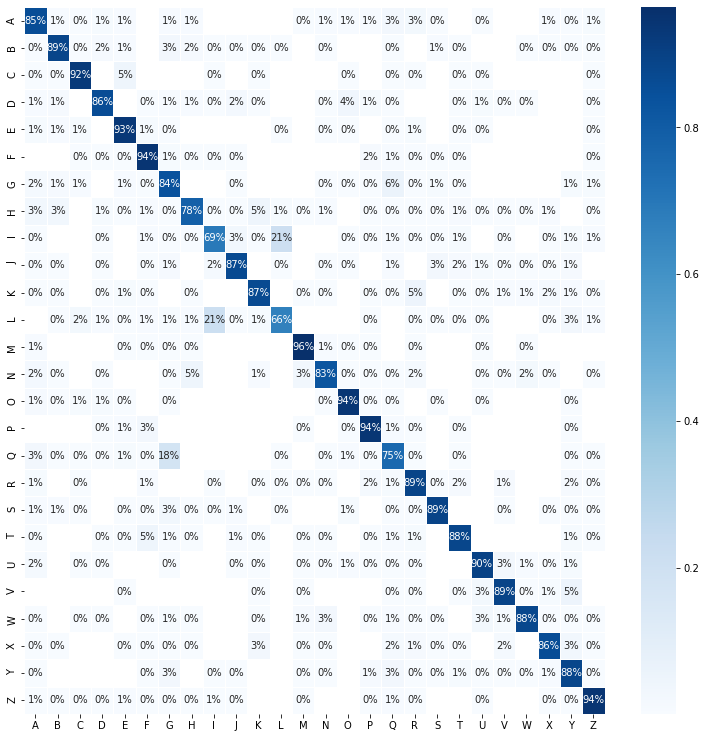

In [20]:
_ = cm_sklearn(X_test, y_test, model)

### From images

In [21]:
import re
import os

IMAGES = sorted([x for x in os.listdir(BASE_DIR.joinpath('images')) if re.search(r'letters_\d+_[A-Z]', x)])

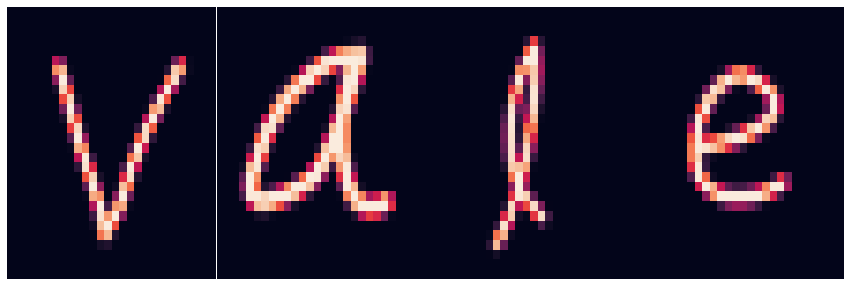

The word predicted is: HALC


In [22]:
predict_letter_sklearn(BASE_DIR.joinpath('images'), IMAGES, model)

### Export

In [23]:
import pickle

with open(BASE_DIR.joinpath('0504_letters_model.pkl'), 'wb') as f:
    pickle.dump(model, f)

## ANN

### Preprocessing

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

prep_ann = Pipeline([('dim_red', pca), ('scaler', mmx)])
X_ann = prep_ann.fit_transform(X_train)
y_ann = le.fit_transform(y_train)

### Arquitectura

In [25]:
model_ann, y_ann = ann_sequential_builder(X_ann, y_ann, [100,200,100],['tanh','relu','relu'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               48400     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 26)                2626      
Total params: 91,326
Trainable params: 91,326
Non-trainable params: 0
_________________________________________________________________
None


2021-08-01 20:42:42.012338: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training

In [26]:
model_ann.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

In [27]:
X_ann_test = prep_ann.transform(X_test)
y_ann_test = to_categorical(le.transform(y_test))

In [28]:
model_ann.fit(X_ann, y_ann, epochs=200, batch_size=5000, validation_data=(X_ann_test, y_ann_test))

2021-08-01 20:42:43.539104: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
22/22 [==============================] - 15s 37ms/step - loss: 3.2642 - accuracy: 0.0464 - val_loss: 3.2299 - val_accuracy: 0.0825
Epoch 2/200
22/22 [==============================] - 0s 18ms/step - loss: 3.2125 - accuracy: 0.0947 - val_loss: 3.1411 - val_accuracy: 0.1831
Epoch 3/200
22/22 [==============================] - 0s 18ms/step - loss: 3.0965 - accuracy: 0.1958 - val_loss: 2.9527 - val_accuracy: 0.1966
Epoch 4/200
22/22 [==============================] - 0s 18ms/step - loss: 2.8714 - accuracy: 0.2341 - val_loss: 3.1768 - val_accuracy: 0.0902
Epoch 5/200
22/22 [==============================] - 0s 18ms/step - loss: 2.8011 - accuracy: 0.2006 - val_loss: 2.4590 - val_accuracy: 0.3361
Epoch 6/200
22/22 [==============================] - 0s 17ms/step - loss: 2.3982 - accuracy: 0.3553 - val_loss: 2.2416 - val_accuracy: 0.4004
Epoch 7/200
22/22 [==============================] - 0s 18ms/step - loss: 2.2120 - accuracy: 0.3900 - val_loss: 2.1006 - val_accuracy: 0.3998
Epoch

### Confussion Matrix

Accuracy de 86.26%


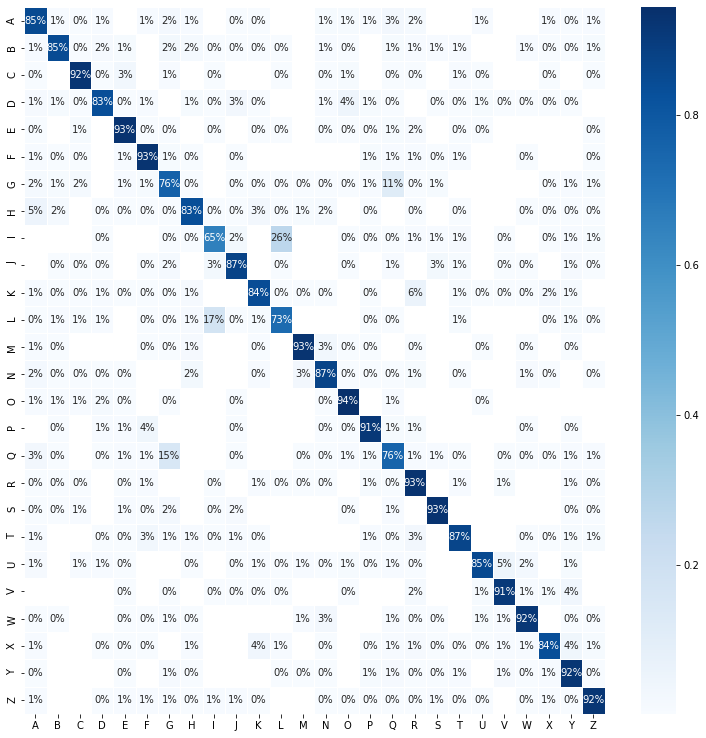

In [29]:
_ = cm_keras(X_ann_test, y_ann_test, model_ann, le)

### From images

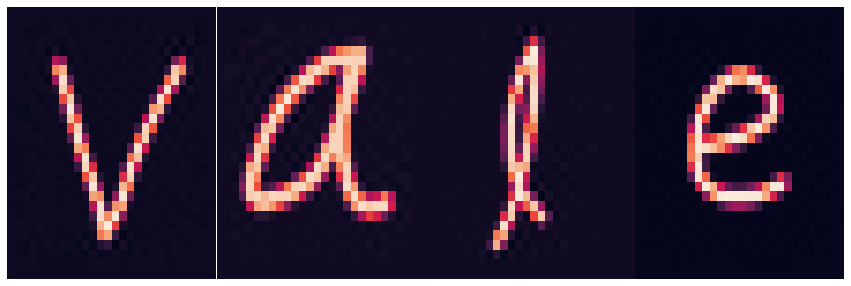

The word predicted is: VAIC


In [30]:
predict_letter_keras(BASE_DIR.joinpath('images'), IMAGES, model_ann, prep_ann, le)

### Export

In [31]:
model_ann.save(BASE_DIR.joinpath('letters_model.h5'))

In [32]:
import h5py
from keras.models import load_model
new_model = load_model(BASE_DIR.joinpath('letters_model.h5'))
f = h5py.File(BASE_DIR.joinpath('letters_model.h5'), 'r')
print(list(f.keys()))

['model_weights', 'optimizer_weights']


## End

In [33]:
time_exp(time.time() - start)
tone()

31 minutos con 8.03 segundos
